## 策略逻辑：
1. 60分钟看长短期MA趋势， 15分钟做均线择时。
2. 加1：2的止损止盈比例
---
## 增加代码
1. onBar编辑止损监控的洗价器
2. self.cancelAll(): 撤掉为下的单子，避免重复下单

In [1]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'MultiFrameMaStrategy'
    author = u'用Python的交易员'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位
    
    # 策略参数
    fastWindow = 40     # 快速均线参数
    slowWindow = 70     # 慢速均线参数
    initDays = 1       # 初始化数据所用的天数
    stopRatio = 0.085   # 止损比例
    
    # 策略变量
    fastMa0 = EMPTY_FLOAT   # 当前最新的快速EMA
    fastMa1 = EMPTY_FLOAT   # 上一根的快速EMA
    slowMa0 = EMPTY_FLOAT   # 当前最新的慢速EMA
    slowMa1 = EMPTY_FLOAT   # 上一根的慢速EMA
    transactionPrice = EMPTY_FLOAT # 记录成交价格
    maTrend = 0             # 均线趋势，多头1，空头-1
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'fastWindow',
                 'slowWindow',
                 'stopRatio']  
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'fastMa0',
               'fastMa1',
               'slowMa0',
               'slowMa1',
               'maTrend',
               'transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(MultiFrameMaStrategy, self).__init__(ctaEngine, setting)
        
        # 生成仓位记录的字典
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
        
        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }
        
        
        self.bg15 = BarGenerator(self.onBar, 15, self.on15MinBar)
        self.bg15Dict = {
            sym: self.bg15
            for sym in self.symbolList
        }
        
        # 生成Bar数组
        self.am60Dict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
      
        self.am15Dict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        # 初始化仓位字典
        self.ctaEngine.initPosition(self)
        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""

        symbol = bar.vtSymbol
        # 基于60分钟判断趋势过滤，因此先更新
        bg60 = self.bg60Dict[symbol]
        bg60.updateBar(bar)
        
        # 基于15分钟判断
        bg15 = self.bg15Dict[symbol]
        bg15.updateBar(bar)
        
        # 洗价器
        if (self.posDict[self.Longpos] > 0):
            if (bar.close<self.transactionPrice*(1-self.stopRatio)) or (bar.close>self.transactionPrice*(1+2*self.stopRatio)):
                self.cancelAll()
                self.sell(symbol,bar.close*0.9, 1)
        elif (self.posDict[self.Shortpos] > 0):
            if (bar.close>self.transactionPrice*(1+self.stopRatio)) or  (bar.close<self.transactionPrice*(1-2*self.stopRatio)):
                self.cancelAll()
                self.cover(symbol,bar.close*1.1, 1)
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """60分钟K线推送"""
        symbol = bar.vtSymbol
        am60 = self.am60Dict[symbol]
        am60.updateBar(bar)
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastWindow)
        slowMa = ta.MA(am60.close, self.slowWindow)
#         print(fastMa)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend = 1
        else:
            self.maTrend = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll() # 全部撤单
        symbol = bar.vtSymbol
        
        
        am15 = self.am15Dict[symbol]
        am15.updateBar(bar)
        if not am15.inited:
            return

        fastMa = ta.EMA(am15.close, self.fastWindow)
       
        self.fastMa0 = fastMa[-1]
        self.fastMa1 = fastMa[-2]
        
        slowMa = ta.EMA(am15.close, self.slowWindow)
        self.slowMa0 = slowMa[-1]
        self.slowMa1 = slowMa[-2]

        # 判断买卖
        crossOver = self.fastMa0>self.fastMa1 and self.slowMa0>self.slowMa1     # 均线上涨
        crossBelow = self.fastMa0<self.fastMa1 and self.slowMa0<self.slowMa1    # 均线下跌
        

        
        # 金叉和死叉的条件是互斥
        if crossOver and self.maTrend==1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.buy(symbol,bar.close*1.1, 1)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[self.Shortpos] == 1:
                self.cancelAll()
                self.cover(symbol,bar.close*1.1, 1)
                self.buy(symbol,bar.close*1.1, 1)

        # 死叉和金叉相反
        elif crossBelow and self.maTrend==-1:
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.short(symbol,bar.close*0.9, 1)
            elif self.posDict[self.Longpos] == 1:
                self.cancelAll()
                self.sell(symbol,bar.close*0.9, 1)
                self.short(symbol,bar.close*0.9, 1)

#         print(self.posDict)
        # 发出状态更新事件
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        self.transactionPrice = trade.price
#         pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 配置引擎参数

In [2]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20180101',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180630')
    # 配置回测引擎参数
    engine.setSlippage(0.2)     # 设置滑点为股指1跳
    engine.setRate(1/1000)   # 设置手续费万0.3
    engine.setSize(1)         # 设置股指合约大小
    # engine.setPriceTick(0.0001)    # 设置股指最小价格变动
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    d = {'symbolList':['tBTCUSD:bitfinex']}          # 策略参数配置
    engine.initStrategy(MultiFrameMaStrategy, d)    # 创建策略对象
    engine.runBacktesting()

2018-07-14 14:15:23.217742	开始回测
2018-07-14 14:15:23.217742	策略初始化
2018-07-14 14:15:23.217742	载入历史数据。数据范围:[20171231,20180101)
2018-07-14 14:15:23.384572	载入完成，数据量：1414
2018-07-14 14:15:23.394562	策略初始化完成
2018-07-14 14:15:23.394562	策略启动完成
2018-07-14 14:15:23.394562	开始回放回测数据,回测范围:[20180101,20180701)
2018-07-14 14:15:23.395560	载入历史数据。数据范围:[20180101,20180311)
2018-07-14 14:15:31.467320	载入完成，数据量：99357
2018-07-14 14:15:31.467320	当前回放数据:[20180101,20180311)
2018-07-14 14:15:32.632130	载入历史数据。数据范围:[20180311,20180519)
2018-07-14 14:15:40.967621	载入完成，数据量：99073
2018-07-14 14:15:41.003583	当前回放数据:[20180311,20180519)
2018-07-14 14:15:42.184378	载入历史数据。数据范围:[20180519,20180701)
2018-07-14 14:15:47.154303	载入完成，数据量：61359
2018-07-14 14:15:47.192265	当前回放数据:[20180519,20180701)
2018-07-14 14:15:47.981460	数据回放结束ss: 100%    


In [3]:
# 显示前10条成交记录
for i in range(1000):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

TradeID: 1, Time: 2018-01-04 07:31:00, Direction: 多, Price: 15019.0, Volume: 1
TradeID: 2, Time: 2018-01-08 16:01:00, Direction: 空, Price: 15886.0, Volume: 1
TradeID: 3, Time: 2018-01-08 16:01:00, Direction: 空, Price: 15886.0, Volume: 1
TradeID: 4, Time: 2018-01-11 11:53:00, Direction: 多, Price: 13160.0, Volume: 1
TradeID: 5, Time: 2018-01-11 12:01:00, Direction: 空, Price: 13261.0, Volume: 1
TradeID: 6, Time: 2018-01-13 20:38:00, Direction: 多, Price: 14419.0, Volume: 1
TradeID: 7, Time: 2018-01-13 23:01:00, Direction: 多, Price: 14374.0, Volume: 1
TradeID: 8, Time: 2018-01-14 20:40:00, Direction: 空, Price: 13152.0, Volume: 1
TradeID: 9, Time: 2018-01-15 07:01:00, Direction: 多, Price: 13546.0, Volume: 1
TradeID: 10, Time: 2018-01-15 10:31:00, Direction: 空, Price: 13424.0, Volume: 1
TradeID: 11, Time: 2018-01-15 10:31:00, Direction: 空, Price: 13424.0, Volume: 1
TradeID: 12, Time: 2018-01-16 17:50:00, Direction: 多, Price: 11125.0, Volume: 1
TradeID: 13, Time: 2018-01-16 18:01:00, Direction

TradeID: 130, Time: 2018-06-21 21:01:00, Direction: 空, Price: 6716.1, Volume: 1
TradeID: 131, Time: 2018-06-21 21:01:00, Direction: 空, Price: 6716.1, Volume: 1
TradeID: 132, Time: 2018-06-26 06:01:00, Direction: 多, Price: 6268.8, Volume: 1
TradeID: 133, Time: 2018-06-26 06:01:00, Direction: 多, Price: 6268.8, Volume: 1
TradeID: 134, Time: 2018-06-27 22:01:00, Direction: 空, Price: 6094.0, Volume: 1
TradeID: 135, Time: 2018-06-27 22:01:00, Direction: 空, Price: 6094.0, Volume: 1


KeyError: '136'

2018-07-14 14:22:50.850719	计算按日统计结果
2018-07-14 14:22:50.876692	------------------------------
2018-07-14 14:22:50.876692	首个交易日：	2018-01-01
2018-07-14 14:22:50.876692	最后交易日：	2018-06-30
2018-07-14 14:22:50.876692	总交易日：	181
2018-07-14 14:22:50.876692	盈利交易日	94
2018-07-14 14:22:50.876692	亏损交易日：	84
2018-07-14 14:22:50.876692	起始资金：	1000000
2018-07-14 14:22:50.876692	结束资金：	1,009,306.07
2018-07-14 14:22:50.876692	总收益率：	0.93%
2018-07-14 14:22:50.876692	年化收益：	1.23%
2018-07-14 14:22:50.876692	总盈亏：	9,306.07
2018-07-14 14:22:50.876692	最大回撤: 	-4,434.99
2018-07-14 14:22:50.877691	百分比最大回撤: -0.44%
2018-07-14 14:22:50.877691	总手续费：	1,282.02
2018-07-14 14:22:50.877691	总滑点：	27.8
2018-07-14 14:22:50.877691	总成交金额：	1,282,016.59
2018-07-14 14:22:50.877691	总成交笔数：	139
2018-07-14 14:22:50.877691	日均盈亏：	51.41
2018-07-14 14:22:50.877691	日均手续费：	7.08
2018-07-14 14:22:50.877691	日均滑点：	0.15
2018-07-14 14:22:50.877691	日均成交金额：	7,082.96
2018-07-14 14:22:50.877691	日均成交笔数：	0.77
2018-07-14 14:22:50.877691	日均收益率：	0.01%
2018-07-1

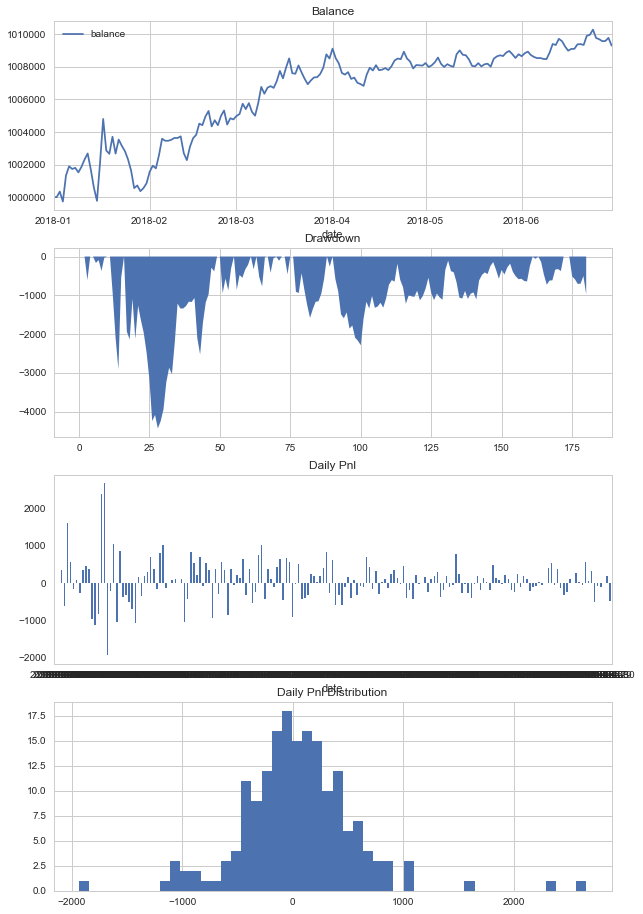

2018-07-14 14:22:52.557976	计算回测结果
2018-07-14 14:22:52.562971	------------------------------
2018-07-14 14:22:52.563970	第一笔交易：	2018-01-07 06:18:00
2018-07-14 14:22:52.563970	最后一笔交易：	2018-06-30 23:59:00
2018-07-14 14:22:52.563970	总交易次数：	70
2018-07-14 14:22:52.563970	总盈亏：	9,299.49
2018-07-14 14:22:52.563970	最大回撤: 	-4,749.01
2018-07-14 14:22:52.563970	平均每笔盈利：	132.85
2018-07-14 14:22:52.563970	平均每笔滑点：	0.4
2018-07-14 14:22:52.563970	平均每笔佣金：	18.41
2018-07-14 14:22:52.563970	胜率		37.14%
2018-07-14 14:22:52.563970	盈利交易平均值	1,048.56
2018-07-14 14:22:52.563970	亏损交易平均值	-408.25
2018-07-14 14:22:52.563970	盈亏比：	2.57


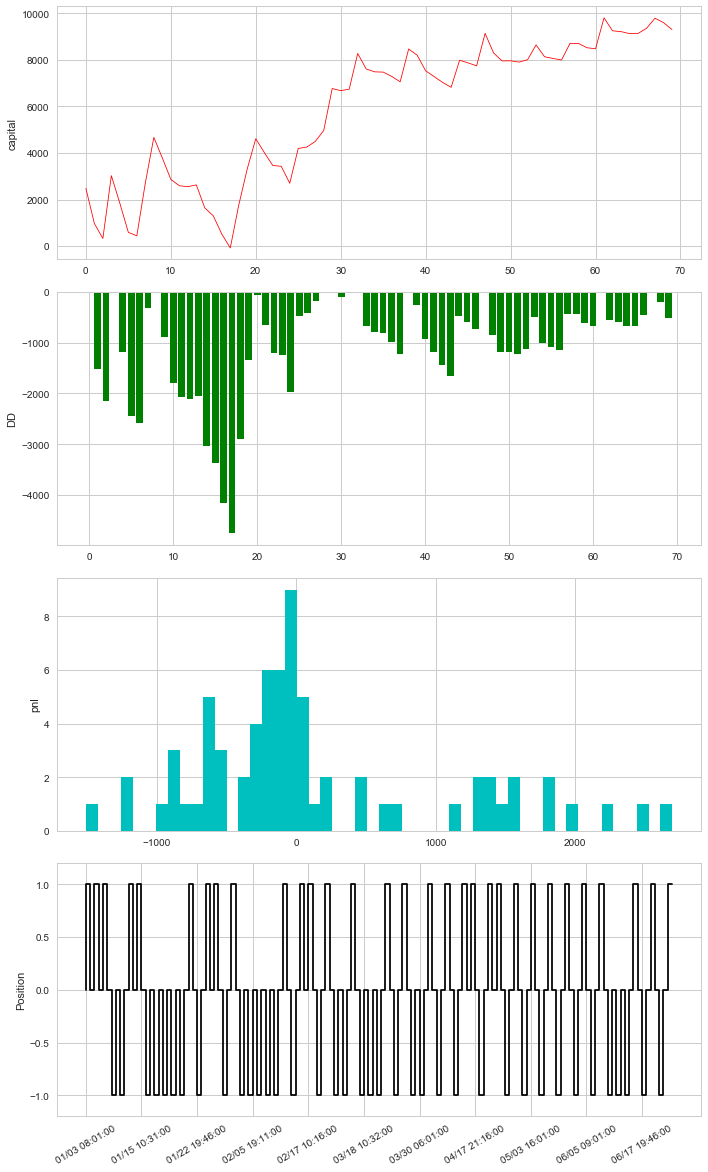

In [3]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

## 吊灯止损
使用字典保存最高最低点

In [66]:
from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta

########################################################################
# 策略继承CtaTemplate
class TrailingMaATRStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'TrailingMaATRStrategy'
    author = u'ChannelCMT'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位
    
    # 策略参数
    fastWindow = 40     # 快速均线参数
    slowWindow = 70     # 慢速均线参数
    initDays = 1       # 初始化数据所用的天数
    trailingPercent = 6.8
    
    # 策略变量
    fastMa0 = EMPTY_FLOAT    # 当前最新的快速EMA
    fastMa1 = EMPTY_FLOAT    # 上一根的快速EMA
    slowMa0 = EMPTY_FLOAT    # 当前最新的慢速EMA
    slowMa1 = EMPTY_FLOAT    # 上一根的慢速EMA
    maTrend = EMPTY_FLOAT    # 均线趋势，多头1，空头-1
    atrValue = EMPTY_FLOAT
    longStop = EMPTY_FLOAT
    shortStop = EMPTY_FLOAT
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'fastWindow',
                 'slowWindow',
                 'atrPeriod',
                'trailingPercent']  
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'fastMa0',
               'fastMa1',
               'slowMa0',
               'slowMa1',
               'maTrend',
               'atrValue',
               'longStop',
               'shortStop']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(TrailingMaATRStrategy, self).__init__(ctaEngine, setting)
        
        # 生成仓位记录的字典
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }
        
        
        self.bg15 = BarGenerator(self.onBar, 15, self.on15MinBar)
        self.bg15Dict = {
            sym: self.bg15
            for sym in self.symbolList
        }
        
        # 生成Bar数组
        self.am60Dict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
      
        self.am15Dict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
        
        self.amDict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
        
        self.intraTradeHighDict = {}
        self.intraTradeLowDict = {}

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        # 初始化仓位字典
        self.ctaEngine.initPosition(self)

        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

        
    #自定义算法----------------------------------------------------------------------
    
    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        self.cancelAll()
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
        # 基于60分钟判断趋势过滤，因此先更新
        bg60 = self.bg60Dict[symbol]
        bg60.updateBar(bar)
        
        # 基于15分钟判断
        bg15 = self.bg15Dict[symbol]
        bg15.updateBar(bar)
        
        
        # 洗价器
        if self.posDict[self.Longpos] == 0 and self.posDict[self.Shortpos] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999

        # 持有多头仓位
        elif self.posDict[self.Longpos] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.intraTradeLowDict[symbol] = bar.low
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPercent/100)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[self.Longpos])

#         # 持有空头仓位
        elif self.posDict[self.Shortpos] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.intraTradeHighDict[symbol] = bar.high
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPercent/100)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[self.Shortpos])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """60分钟K线推送"""
        symbol = bar.vtSymbol
        am60 = self.am60Dict[symbol]
        am60.updateBar(bar)
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastWindow)
        slowMa = ta.MA(am60.close, self.slowWindow)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend = 1
        else:
            self.maTrend = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll()
        symbol = bar.vtSymbol
        am15 = self.am15Dict[symbol]
        am15.updateBar(bar)
        
        if not am15.inited:
            return
        
        fastMa = ta.EMA(am15.close, self.fastWindow)
       
        self.fastMa0 = fastMa[-1]
        self.fastMa1 = fastMa[-2]
        
        slowMa = ta.EMA(am15.close, self.slowWindow)
        self.slowMa0 = slowMa[-1]
        self.slowMa1 = slowMa[-2]

        # 判断买卖
        crossOver = self.fastMa0>self.fastMa1 and self.slowMa0>self.slowMa1     # 均线上涨
        crossBelow = self.fastMa0<self.fastMa1 and self.slowMa0<self.slowMa1    # 均线下跌
        
        # 金叉和死叉的条件是互斥
        if crossOver and self.maTrend==1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.buy(symbol,bar.close*1.1, 1)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[self.Shortpos] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.1, 1)
                self.buy(symbol,bar.close*1.1, 1)

        # 死叉和金叉相反
        elif crossBelow and self.maTrend==-1:
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.short(symbol,bar.close*0.9, 1)
            elif self.posDict[self.Longpos] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.9, 1)
                self.short(symbol,bar.close*0.9, 1)


        # 发出状态更新事件
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         self.transactionPrice = trade.high
#         print('high:',self.intraTradeHighDict)
#         print('low:',self.intraTradeLowDict)
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [67]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20180101',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180630')
    # 配置回测引擎参数
    engine.setSlippage(0.2)     # 设置滑点为股指1跳
    engine.setRate(1/1000)   # 设置手续费万0.3
    engine.setSize(1)         # 设置股指合约大小
    # engine.setPriceTick(0.0001)    # 设置股指最小价格变动
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    d = {'symbolList':['tBTCUSD:bitfinex']}          # 策略参数配置
    engine.initStrategy(TrailingMaATRStrategy, d)    # 创建策略对象
    engine.runBacktesting()

2018-07-10 21:27:38.190070	开始回测
2018-07-10 21:27:38.190070	策略初始化
2018-07-10 21:27:38.190070	载入历史数据。数据范围:[20171231,20180101)
2018-07-10 21:27:38.218042	策略初始化完成
2018-07-10 21:27:38.218042	策略启动完成
2018-07-10 21:27:38.218042	开始回放回测数据,回测范围:[20180101,20180701)
2018-07-10 21:27:38.219042	载入历史数据。数据范围:[20180101,20180701)
2018-07-10 21:28:00.107686	载入完成，数据量：259789
2018-07-10 21:28:00.107686	当前回放数据:[20180101,20180701)
2018-07-10 21:28:03.607112	数据回放结束ss: 100%    


2018-07-10 21:28:03.615103	计算按日统计结果
2018-07-10 21:28:03.638080	------------------------------
2018-07-10 21:28:03.638080	首个交易日：	2018-01-01
2018-07-10 21:28:03.638080	最后交易日：	2018-06-30
2018-07-10 21:28:03.638080	总交易日：	181
2018-07-10 21:28:03.638080	盈利交易日	93
2018-07-10 21:28:03.638080	亏损交易日：	84
2018-07-10 21:28:03.638080	起始资金：	1000000
2018-07-10 21:28:03.639080	结束资金：	1,006,479.46
2018-07-10 21:28:03.639080	总收益率：	0.65%
2018-07-10 21:28:03.639080	年化收益：	0.86%
2018-07-10 21:28:03.639080	总盈亏：	6,479.46
2018-07-10 21:28:03.639080	最大回撤: 	-4,682.86
2018-07-10 21:28:03.639080	百分比最大回撤: -0.47%
2018-07-10 21:28:03.639080	总手续费：	2,000.66
2018-07-10 21:28:03.639080	总滑点：	42.0
2018-07-10 21:28:03.639080	总成交金额：	2,000,655.23
2018-07-10 21:28:03.639080	总成交笔数：	210
2018-07-10 21:28:03.640079	日均盈亏：	35.8
2018-07-10 21:28:03.640079	日均手续费：	11.05
2018-07-10 21:28:03.640079	日均滑点：	0.23
2018-07-10 21:28:03.640079	日均成交金额：	11,053.34
2018-07-10 21:28:03.640079	日均成交笔数：	1.16
2018-07-10 21:28:03.640079	日均收益率：	0.0%
2018-07-1

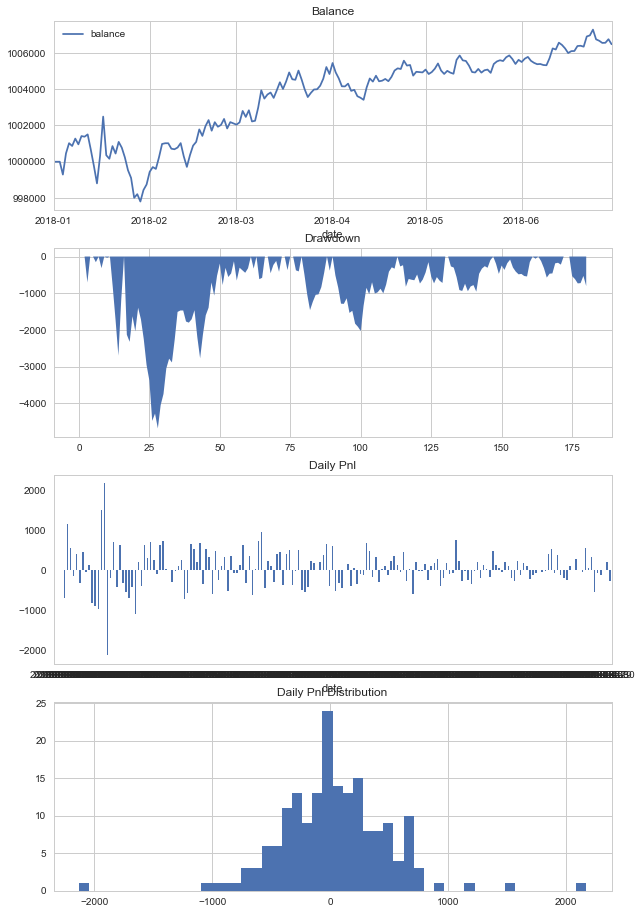

2018-07-10 21:28:05.411269	计算回测结果
2018-07-10 21:28:05.420261	------------------------------
2018-07-10 21:28:05.420261	第一笔交易：	2018-01-04 16:31:00
2018-07-10 21:28:05.420261	最后一笔交易：	2018-06-30 06:32:00
2018-07-10 21:28:05.420261	总交易次数：	105
2018-07-10 21:28:05.420261	总盈亏：	6,479.46
2018-07-10 21:28:05.420261	最大回撤: 	-4,297.41
2018-07-10 21:28:05.420261	平均每笔盈利：	61.71
2018-07-10 21:28:05.420261	平均每笔滑点：	0.4
2018-07-10 21:28:05.420261	平均每笔佣金：	19.05
2018-07-10 21:28:05.420261	胜率		42.86%
2018-07-10 21:28:05.420261	盈利交易平均值	607.05
2018-07-10 21:28:05.420261	亏损交易平均值	-347.3
2018-07-10 21:28:05.420261	盈亏比：	1.75


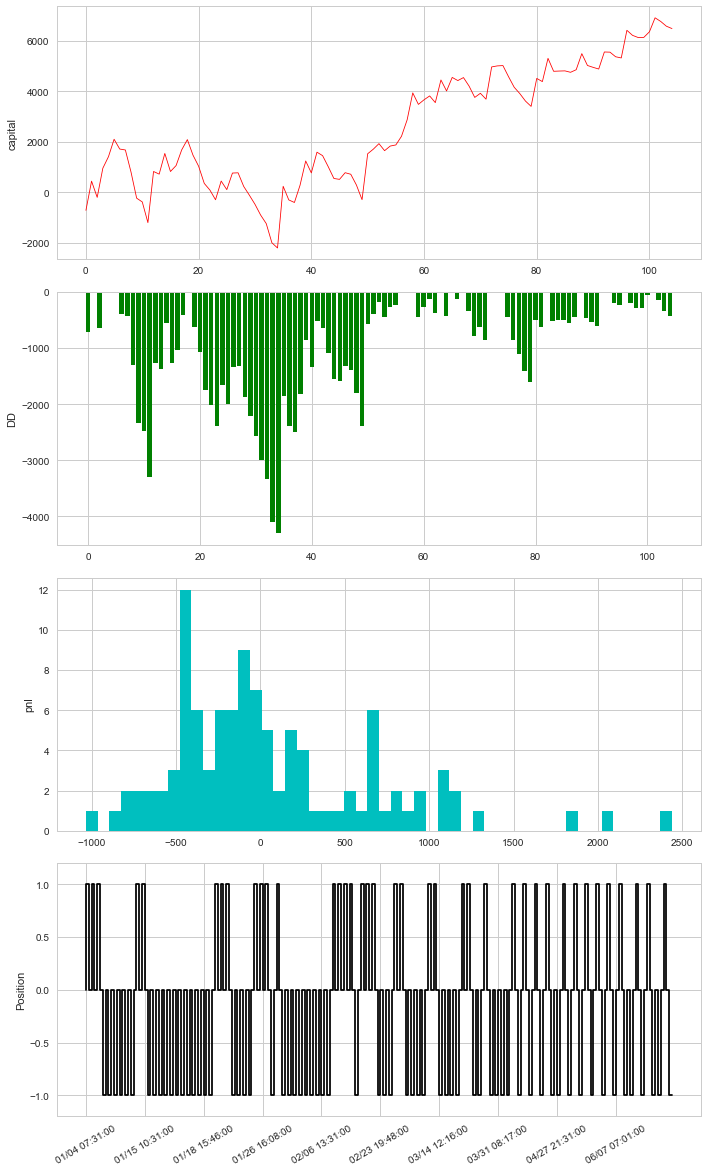

In [68]:
    # 显示逐日回测结果
    engine.showDailyResult()
    # 显示逐笔回测结果
    engine.showBacktestingResult()